# Assignment 3 
<br>
- Aman Joshi
- 2018201097

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from math import floor

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [3]:
def splitImage(image):
    width = image.shape[1]
    image_left = image[:, :floor(width / 2)]
    image_right = image[:, floor(width / 2):]
    return image_left, image_right

# Question 1: Perform Dense SIFT-based matching on a given pairs of
images.
Dense SIFT is SIFT on all different window sizes, unlike normal SIFT which matches images based on best
feature descriptors. Since the no.of features is more, it works better than SIFT, but is computationally more
costly. My Implementation:
- Instead of using sift.detectAndCompute(), used cv2.KeyPoint() to compute keyPoints for each window
of window size = 8, radius = 16 for both the images.
- Passed the above keyPoints to cv2.BFMatcher to get the matching points.
- Used cv2.drawMatchesKnn() to draw lines between the matching desciptors

In [4]:
class denseSIFT():
    def __init__(self, step=8, radius=8):
        self.step = 8
        self.radius = 8
        self.sift = cv.xfeatures2d.SIFT_create()
        self.bf = cv.BFMatcher()

    def gray(self, img):
        return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    def compute_key_points(self, img):
        gray = self.gray(img)
        key_points = []
        for i in range(0, img.shape[0], self.step):
            for j in range(0, img.shape[1], self.step):
                key_points.append(cv.KeyPoint(i, j, self.radius))
        features = self.sift.compute(gray, key_points)
        return features

    def __call__(self, image1, image2, distance=0.5):
        key_points_left, desc_left = self.compute_key_points(image1)
        key_points_right, desc_right = self.compute_key_points(image2)
        matches = self.bf.knnMatch(desc_left, desc_right, k=2)
        good = []
        for m, n in matches:
            if m.distance < distance * n.distance:
                good.append([m])
        good
        img_output = cv.drawMatchesKnn(
            image1,
            key_points_left,
            image2,
            key_points_right,
            good,
            None,
            flags=2)
        return img_output

In [5]:
image_paths = [
    "./Stereo Images/Stereo_Pair1.jpg", "./Stereo Images/Stereo_Pair2.jpg",
    "./Stereo Images/Stereo_Pair3.jpg"
]

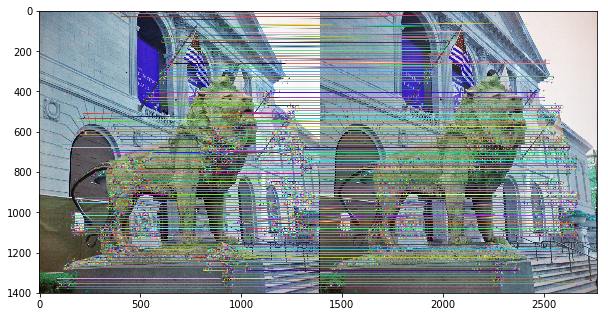

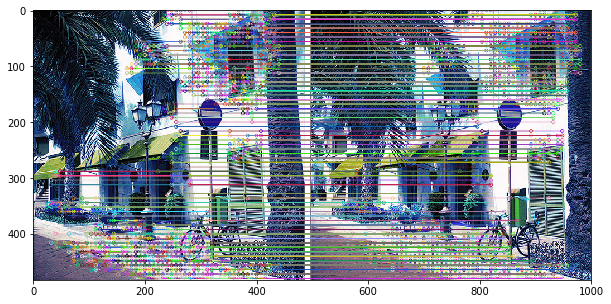

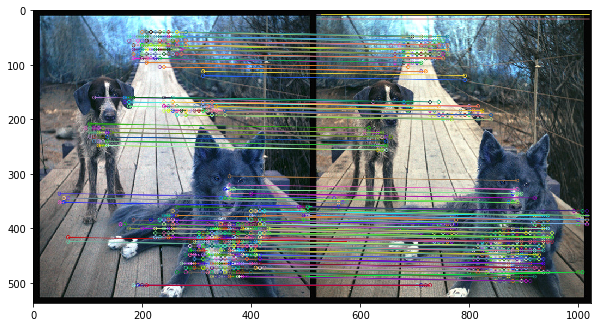

In [6]:
matcher = denseSIFT()
for image_path in image_paths:
    image = cv.imread(image_path)
    width = image.shape[1]
    image_left, image_right = splitImage(image)
    image_output = matcher(image_left, image_right)
    plt.imshow(image_output)
    plt.show()

# Question - 2: Perform Intensity Window-based correlation on a set of images
Here, we use a sliding window method to get the template match of a template in image1 in image2. The
matching is done based on window intensities (template is a cropped part of an image based on window
size).
My Implementation:
- Used a square window template of 128 pixels.
- For each window in image1, found the best match in image2 using cv2.matchTemplate().
- Used cv2.TM_CCORR_NORMED method for template matching.
- It is brute force based window match, the matched window might be anywhere in the second image.

In [7]:
class windowBasedMatching():
    def __init__(self, method=cv.TM_CCORR_NORMED, window=128):
        self.method = method
        self.window = window

    def match(self, image, template):
        res = cv.matchTemplate(image, template, self.method)
        h, w, _ = template.shape
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if self.method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        center = (top_left[0] + floor(self.window / 2),
                  top_left[1] + floor(self.window / 2))
        return center

    def find_center(self, top, bottom):
        t = (top[0] + bottom[0]) / 2
        b = (top[1] + bottom[1]) / 2
        return (floor(t), floor(b))

    def __call__(self, image1, image2):
        full_image = full_img = np.concatenate((image1, image2), axis=1)
        h, w, _ = image1.shape
        for i in range(0, h, self.window):
            for j in range(0, w, self.window):
                template = image1[i:i + self.window, j:j + self.window]
                center1 = (i + floor(self.window / 2),
                           j + floor(self.window / 2))
                center2 = self.match(image2, template)
                center2 = (center2[0] + floor(width / 2), center2[1])
                cv.circle(
                    full_image,
                    center1,
                    4, (0, 255, 0),
                    thickness=1,
                    lineType=8,
                    shift=0)
                cv.circle(
                    full_image,
                    center2,
                    4, (0, 255, 0),
                    thickness=1,
                    lineType=8,
                    shift=0)
                cv.line(full_image, center1, center2, (0, 255, 0), 2)
        return full_image

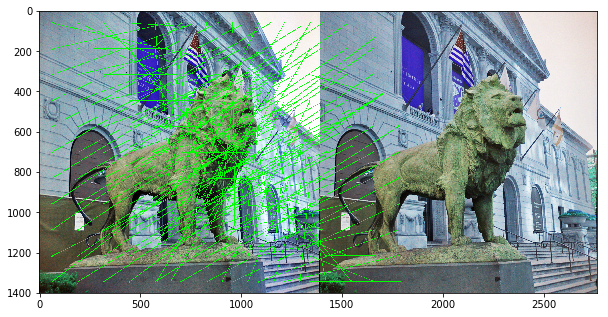

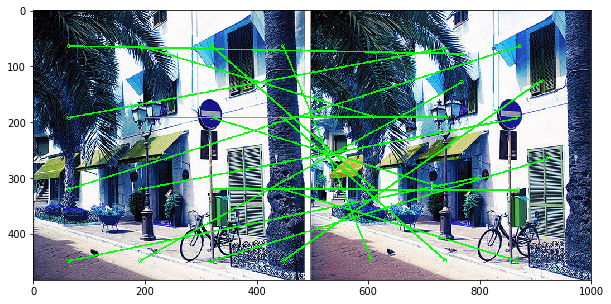

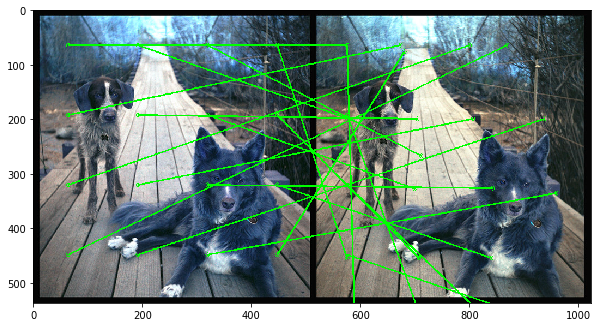

In [8]:
for image_path in image_paths:
    image = cv.imread(image_path)
    image_left, image_right = splitImage(image)
    image_output = windowBasedMatching()(image1=image_left, image2=image_right)
    plt.imshow(image_output)
    plt.show()

# Question 3: Compare Dense SIFT and Intesity based Correlation methods
- Dense SIFT used multiple keypoints(one from each window), and tries to find appropriate match in the other image.
- It is using a brute force Matcher. 
- Intensiy based matching uses a similar window.
- But tries to match it in the other image using intensity values of the window. 
- Since Intensities can match within differnt regions hence poor matching.
- Time taken is almost same but Dense SIFt performs better

# Question 4: Rectify the pairs of images and do denseSIFT and Intensity based correlation
### Rectfying Images
- Get keypoints from sift detect and compute function and Fundamental matrix usinng cv function.
-Using the above keypoints and fundamental matrix F, rectified both the images using cv2.stereoRectifyUncalibrated()

In [9]:
class rectifyImages():
    def __init__(self):
        self.sift = cv.xfeatures2d.SIFT_create()
        self.bf = cv.BFMatcher()

    def compute_descriptors(self, image):
        key_points, descriptor = self.sift.detectAndCompute(image, None)
        return key_points, descriptor

    def match(self, kps1, kps2, des1, des2):
        matches = self.bf.knnMatch(des1, des2, k=2)
        pts1 = []
        pts2 = []
        for m, n in matches:
            if m.distance < self.distance * n.distance:
                pts1.append(kps1[m.queryIdx].pt)
                pts2.append(kps2[m.trainIdx].pt)
        pts1 = np.array(pts1, dtype='int32')
        pts2 = np.array(pts2, dtype='int32')
        return pts1, pts2

    def rectify(self, img1, pts1, img2, pts2):
        F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)
        pts1 = pts1[mask.ravel() == 1]
        pts2 = pts2[mask.ravel() == 1]
        rectFlag, rectM1, rectM2 = cv.stereoRectifyUncalibrated(
            pts1, pts2, F, img1.shape[:2])
        img1 = cv.warpPerspective(img1, rectM1, img1.shape[:2])
        img2 = cv.warpPerspective(img2, rectM2, img2.shape[:2])
        return img1, img2

    def __call__(self, image1, image2, distance=0.5):
        self.distance = distance
        kps1, des1 = self.compute_descriptors(image1)
        kps2, des2 = self.compute_descriptors(image2)
        pts1, pts2 = self.match(kps1, kps2, des1, des2)
        return self.rectify(image1, pts1, image2, pts2)

## Dense SIFT Results:
- Rectify the image and then perform DENSE sift on it.

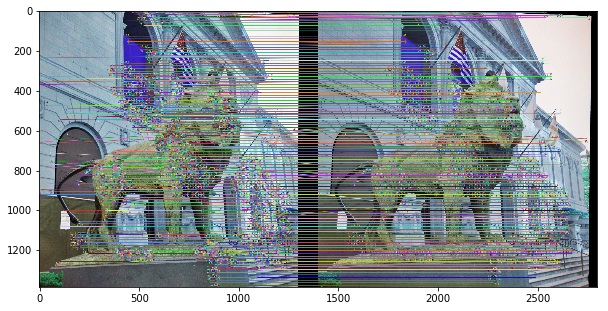

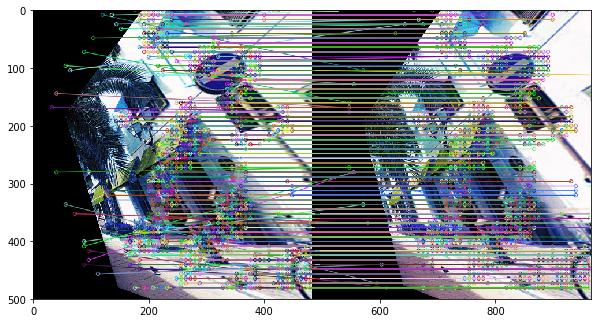

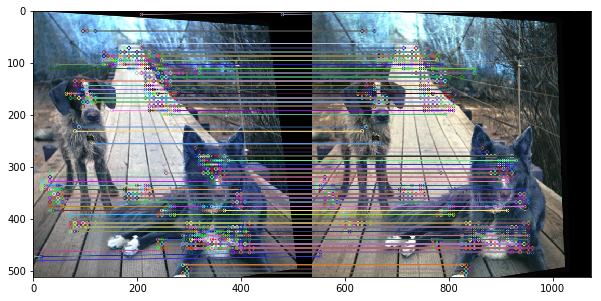

In [10]:
matcher = denseSIFT(radius=16)
for image_path in image_paths:
    image = cv.imread(image_path)
    image_left, image_right = rectifyImages()(*splitImage(image))
    img_output = matcher(image_left, image_right)
    plt.imshow(img_output)
    plt.show()

## Intensity based Results:
- Rectify the image and then perform Intensity based matching on it.

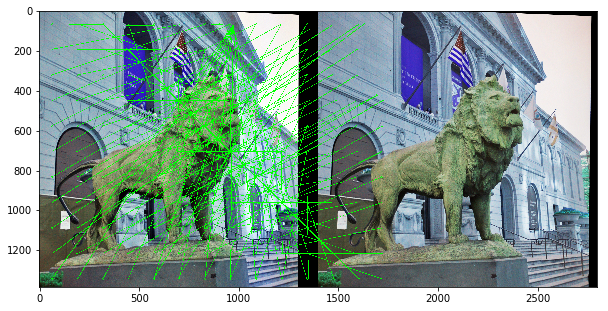

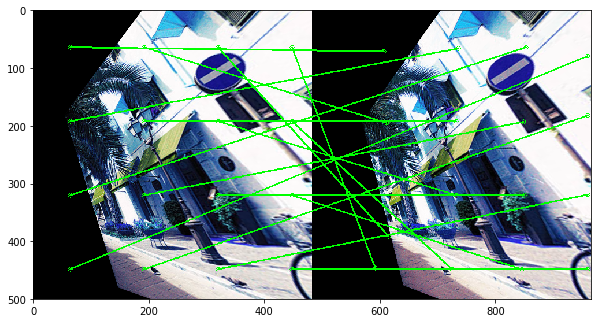

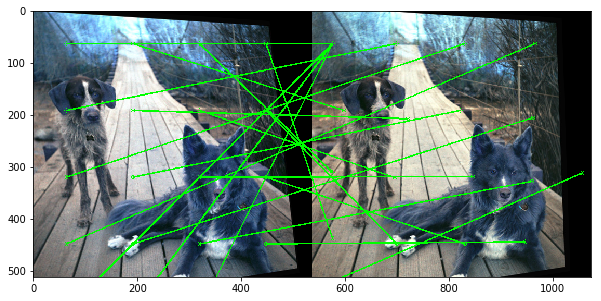

In [11]:
for image_path in image_paths:
    image = cv.imread(image_path)
    image_left, image_right = rectifyImages()(*splitImage(image))
    img_output = windowBasedMatching()(image_left, image_right)
    plt.imshow(img_output)
    plt.show()

# Question - 5: Compare with Greedy Matching and DTW on rectified images
- For greedy matching, for every window of image 1 we find the best match (highest correlation value) in same row of the rectified image of secodn image.
- This may not give best result as it is not taking care of the spatial order.

In [12]:
class greedy_matcher():
    def mean2(self, x):
        y = np.sum(x) / np.size(x)
        return y

    def templateCorrelation(self, a, b):
        a = a - self.mean2(a)
        b = b - self.mean2(b)

        r = (a * b).sum() / np.sqrt((a * a).sum() * (b * b).sum())
        return r

    def fixShape(self, template1, template2):
        template1 = template1.copy()
        template2 = template2.copy()
        if (template1.shape[1] > template2.shape[1]):
            template1 = template1[:, :template2.shape[1]]
        else:
            template2 = template2[:, :template1.shape[1]]
        return template1, template2

    def greedyMatchTemplate(self, template1, img, row):
        max_corr = -1e10
        best_col = 0
        for k in range(0, img.shape[1], self.window):
            template2 = img[row:row + self.window, k:k + self.window]
            t1, t2 = self.fixShape(template1, template2)
            corr = self.templateCorrelation(t1, t2)
            if (corr > max_corr):
                best_col = k
                max_corr = corr
        center = (best_col + floor(self.window / 2),
                  row + floor(self.window / 2))
        return center

    def __call__(self, img1, img2, window):
        self.window = window
        full_img = np.concatenate((img1, img2), axis=1)
        for i in range(0, img1.shape[0], window):
            for j in range(0, img1.shape[1], window):
                template1 = img1[i:i + window, j:j + window]
                center1 = (j + floor(window / 2), i + floor(window / 2))
                center2 = self.greedyMatchTemplate(
                    template1,
                    img2,
                    i,
                )
                center2 = (center2[0] + floor(img1.shape[1]), center2[1])
                cv.circle(
                    full_img,
                    center1,
                    4, (0, 255, 0),
                    thickness=1,
                    lineType=8,
                    shift=0)
                cv.circle(
                    full_img,
                    center2,
                    4, (0, 255, 0),
                    thickness=1,
                    lineType=8,
                    shift=0)
                cv.line(full_img, center1, center2, (0, 255, 0), 2)
        plt.imshow(full_img)
        plt.show()

In [13]:
def computeGreedyMatch(img, distance=0.5, window=128):
    img1, img2 = splitImage(img)
    img1, img2 = rectifyImages()(img1, img2, distance)
    greedy_matcher()(img1, img2, window)

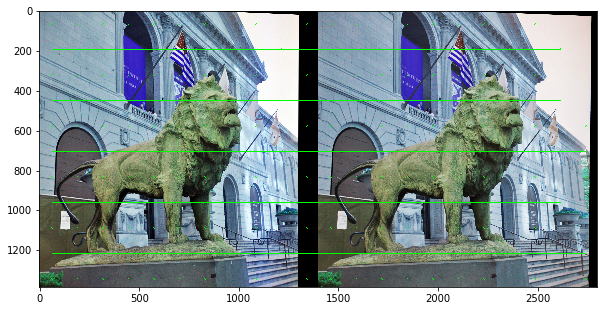

/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


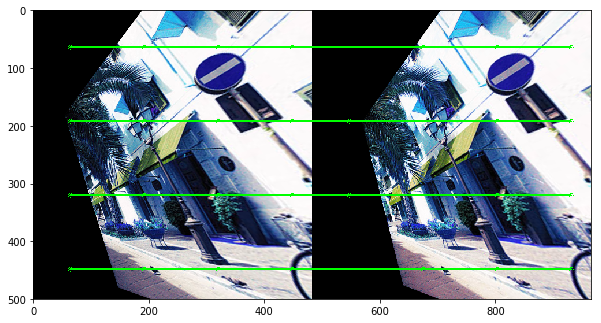

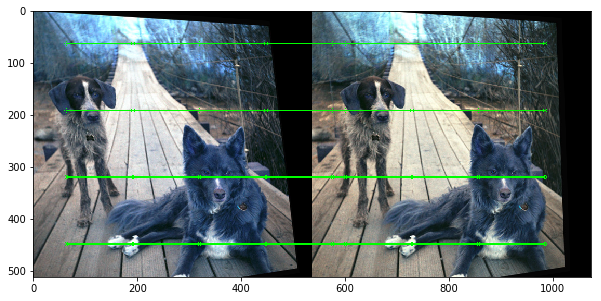

In [14]:
for image_path in image_paths:
    image = cv.imread(image_path)
    computeGreedyMatch(image)

## DTW based matching
- It is Dynamic programming based approach.
- It finds the best matching sequence among both rows of rectified images.
- It returns a good match as we are considering spatial oreder.

In [18]:
class DTW:
    def mean2(self, x):
        y = np.sum(x) / np.size(x)
        return y

    def templateCorrelation(self, a, b):
        a = a - self.mean2(a)
        b = b - self.mean2(b)

        r = (a * b).sum() / np.sqrt((a * a).sum() * (b * b).sum())
        return r

    def fixShape(self, template1, template2):
        template1 = template1.copy()
        template2 = template2.copy()
        if (template1.shape[1] > template2.shape[1]):
            template1 = template1[:, :template2.shape[1]]
        else:
            template2 = template2[:, :template1.shape[1]]
        return template1, template2

    def computeDistance(self, image1, image2):
        distances = []
        for i in range(0, image1.shape[0], self.window):
            temp_dist_i = []
            for j in range(0, image1.shape[1], self.window):
                template1 = image1[i:i + self.window, j:j + self.window]
                temp_dist_j = []
                for k in range(0, image2.shape[1], self.window):
                    template2 = image2[i:i + self.window, k:k + self.window]
                    template1, template2 = self.fixShape(template1, template2)
                    temp_dist_j.append(
                        self.templateCorrelation(template1, template2))
                temp_dist_i.append(temp_dist_j)
            distances.append(temp_dist_i)
        return np.array(distances)

    def __call__(self, image1, image2, window):
        self.window = window
        full_image = np.concatenate((image1, image2), axis=1)
        distances = self.computeDistance(image1, image2)
        for row in range(distances.shape[0]):
            cum_cost = np.zeros((distances.shape[2], distances.shape[1]))
            cum_cost[0, 0] = distances[row][0, 0]
            for i in range(1, distances.shape[1]):
                cum_cost[0, i] = distances[row][0, i] + cum_cost[0, i - 1]
            for i in range(1, distances.shape[2]):
                cum_cost[i, 0] = distances[row][i, 0] + cum_cost[i - 1, 0]
            for i in range(1, distances.shape[2]):
                for j in range(1, distances.shape[1]):
                    cum_cost[i, j] = min(
                        cum_cost[i - 1, j - 1], cum_cost[i - 1, j],
                        cum_cost[i, j - 1]) + distances[row][i, j]
                    d = distances[row][i, j]
                    path = [[distances.shape[1] - 1, distances.shape[2] - 1]]
                    i = distances.shape[2] - 1
                    j = distances.shape[1] - 1
                    while i > 0 and j > 0:
                        if i == 0:
                            j = j - 1
                        elif j == 0:
                            i = i - 1
                        else:
                            if cum_cost[i - 1, j] + d == cum_cost[i, j]:
                                i = i - 1
                            elif cum_cost[i, j - 1] + d == cum_cost[i, j]:
                                j = j - 1
                            else:
                                i = i - 1
                                j = j - 1

                    path.append([j, i])
                path.append([0, 0])
            for i in range(len(path)):
                c1 = (path[i][0] * window + int(window / 2),
                      row * window + int(self.window / 2))
                c2 = (path[i][1] * window + int(window / 2),
                      row * window + int(self.window / 2))
                c2 = (c2[0] + int(image1.shape[1]), c2[1])
                cv.circle(
                    full_image,
                    c1,
                    8, (0, 255, 0),
                    thickness=2,
                    lineType=8,
                    shift=0)
                cv.circle(
                    full_image,
                    c2,
                    8, (0, 255, 0),
                    thickness=2,
                    lineType=8,
                    shift=0)
                cv.line(full_image, c1, c2, (0, 255, 0), 2)
        plt.imshow(full_image)
        plt.show()

In [19]:
def computeDTWMatch(img, distance=0.75, window=128):
    img1, img2 = splitImage(img)
    img1, img2 = rectifyImages()(img1, img2, distance)
    DTW()(img1, img2, window)

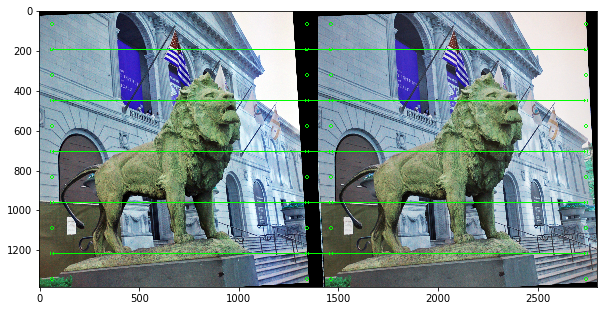

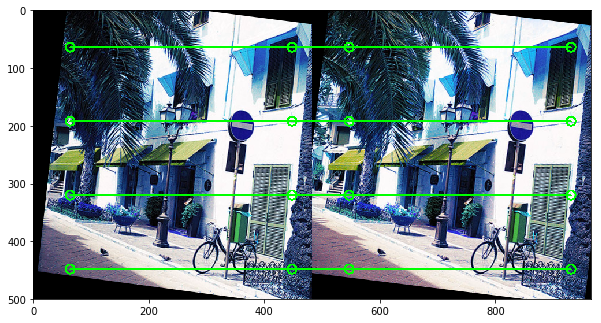

/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


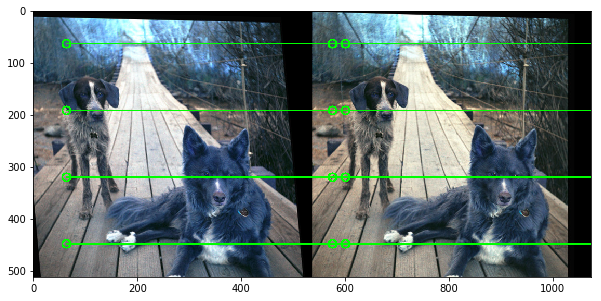

In [20]:
for image_path in image_paths:
    image = cv.imread(image_path)
    computeDTWMatch(image)